# Final Project - Basics of deep learning
Hello dear students,<br> This is the template notebook. Please copy it into your drive.

---
<br>

### Name and ID:
Student 1: Ori Malca 315150599
<br>
Student 2: Kfir Sitalkil 208722660

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/20733/logos/header.png?t=2020-05-14-08-44-45">

# Utils

## Import Libraries

In [ ]:
%%capture
import re
import math
import functools
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import load_img
from keras.preprocessing import image
from sklearn import metrics
from keras import backend as K
from google.colab import drive
from sklearn.neighbors import KNeighborsClassifier
import joblib

!pip install -U --no-cache-dir gdown --pre
!gdown --id 1DS_5kLbzYYzMWtp1WP3x_hxtRBhroJID

## Dataset
Cars196 - 196 different classes of vehicles

### Download Data

In [ ]:
cars196 = tfds.load('Cars196', as_supervised=True, shuffle_files=True)

Dictionary of the labels - maps between the label (int) number and the vehicle model (str)

In [ ]:
label_dic = pd.read_csv('/content/labels_dic.csv', header=None, dtype={0: str}).set_index(0).squeeze().to_dict()

### Function - Plot Single Example
This function receives an image and a label and it will display it on a plot

In [ ]:
def plot_single_example(image, label, label_dic=label_dic):
  car_model_by_label = label_dic[str(label)]
  plt.title(f'Image Label: {car_model_by_label} ({label})')
  plt.imshow(image)

### Split Dataset
Train set contains 8041 examples<br>
Test set contains 8144 examples<br>
**It is allowed to change the ratio between the data sets.**


In [ ]:
cars_train=cars196['train']
cars_test=cars196['test']

# General steps for the whole project
### This steps apply to all the 3 tasks of the project (Transfer Learning, Image Retrieval and End-to-End CNN)

## Global Parameters and functions for the whole project

### Universal parameters of the data

In [ ]:
NUM_OF_CLASSES = 196
HEIGHT, WIDTH = 224, 224
INPUT_SHAPE = (HEIGHT, WIDTH, 3)

### Universal parameters of the models

In [ ]:
BATCH_SIZE = 32

METRICS = ['accuracy', tf.keras.metrics.AUC(),
           tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
           tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(),
           tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()]

### Function to present results and metrics

In [ ]:
def plot_curves(name, history):
  # extract metric names for history and graphs
  metrics = [metric.split("val_", 1)[1] for metric in history.history.keys() if metric.startswith('val_')]
  metrics_graph_names = [m[:-2] if re.search(r'\d+$', m) != None else m for m in metrics]
  
  # plot graphs
  for met, g_name in zip(metrics, metrics_graph_names):
    epochs = range(len(history.history[met]))

    plt.plot(epochs, history.history[met], label=f'training_{g_name}')
    plt.plot(epochs, history.history[f'val_{met}'], label=f'val_{g_name}')
    plt.legend()
    
    plt.title(f'{name} {g_name}:')
    plt.xlabel('epochs')
    plt.ylabel(g_name)
    plt.figure()

### Function to evaluate performence

In [ ]:
# functions for other metrics
def f1score(precision, recall): return (2*precision*recall)/(precision+recall)
def TPR(tp, fn):                return (tp)/(tp+fn)
def TNR(tn, fp):                return (tn)/(tn+fp)
def FPR(fp, tn):                return (fp)/(tn+fp)
def FNR(fn, tp):                return (fn)/(fn+tp)


def evaluate_performence(model, test_ds):
  score = model.evaluate(test_ds)

  column_labels = ["Loss", "Accuracy", "AUC", "Precision", "Recall", "F1 Score", "TPR", "TNR", "FPR", "FNR"]
  
  data = [score[i] for i in range(5)]
  data.append(f1score(score[3], score[4]))
  data.append(TPR(score[5], score[8]))
  data.append(TNR(score[6], score[7]))
  data.append(FPR(score[7], score[6]))
  data.append(FNR(score[8], score[5]))

  fig, ax = plt.subplots(1, 1)
  plt.title(f'{model.name} Performance on test set', fontsize=25)
  df=pd.DataFrame([data], columns=column_labels)
  ax.axis('tight')
  ax.axis('off')
  mytable = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=["Results"],
                     loc="center", colColours=["royalblue"]*len(column_labels), rowColours='yellow')
  mytable.auto_set_column_width(col=list(range(len(df.columns))))
  mytable.auto_set_font_size(False)
  mytable.set_fontsize(20)
  mytable.scale(4, 4)
  plt.show()

### Another function to evaluate performence

In [ ]:
def eval_perf(y_true, y_pred, name):
  data = []
  data.append(metrics.accuracy_score(y_true, y_pred))
  data.append(metrics.balanced_accuracy_score(y_true, y_pred))
  data.append(metrics.precision_score(y_true, y_pred, average='weighted'))
  data.append(metrics.recall_score(y_true, y_pred, average='weighted'))
  data.append(metrics.f1_score(y_true, y_pred, average='weighted'))

  column_labels = ["Accuracy", "Balanced Accuracy", "Precision", "Recall", "F1 Score"]
  
  fig, ax = plt.subplots(1, 1)
  plt.title(f'{name} Performance on test set', fontsize=25)
  df=pd.DataFrame([data], columns=column_labels)
  ax.axis('tight')
  ax.axis('off')
  mytable = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=["Results"],
                     loc="center", colColours=["royalblue"]*len(column_labels), rowColours='yellow')
  mytable.auto_set_column_width(col=list(range(len(df.columns))))
  mytable.auto_set_font_size(False)
  mytable.set_fontsize(20)
  mytable.scale(4, 4)
  plt.show()

### Function to embed tf.data.Dataset using an embedding model

In [ ]:
# A function to extract embeddings for a set of samples
def extract_dataset_embeddings(embedding_model, dataset):
    embeddings = []
    labels = []
    for batch, batch_labels in dataset:
        batch_embeddings = embedding_model.predict(batch)
        embeddings.append(batch_embeddings)
        labels.append(batch_labels)
    return np.concatenate(embeddings), np.concatenate(labels)

## Data Preprocessing for the whole project

### Data Splitting
Merging the dataset and splitting to train (90%), validation (20% of train) and test (10%).

In [ ]:
# Concatenate the train set and test set
cars = cars_train.concatenate(cars_test)

# Calculate the number of examples in the train and test datasets
TRAIN_SIZE = int(0.9 * len(cars))
TEST_SIZE = int(len(cars) - TRAIN_SIZE)

# Create the train and test datasets
train_ds = cars.take(TRAIN_SIZE)
test_ds = cars.skip(TRAIN_SIZE)

# create validation dataset
VALIDATION_SIZE = int(0.2 * len(train_ds))
validation_ds = train_ds.take(VALIDATION_SIZE)

# create train dataset
train_ds = train_ds.skip(VALIDATION_SIZE)

# printing train, validation and test lens:
print(f'train size: {TRAIN_SIZE}, validation size: {VALIDATION_SIZE}, test size: {TEST_SIZE}')

train size: 14566, validation size: 2913, test size: 1619


### Data Transformation
1. Resizing
2. Casting
3. One Hot Encoding
4. Shuffling
5. Dividing to batches

In [ ]:
def transform(x, y):
    x = tf.image.resize(x, (HEIGHT, WIDTH))  # resizing
    x = tf.cast(x, tf.float32)  # casing to float32
    y = tf.one_hot(y, depth=NUM_OF_CLASSES)  # changing labels from sparse to one-hot-encoding
    return x, y

In [ ]:
adapt_ds = train_ds.map(transform, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = adapt_ds.shuffle(len(train_ds)//BATCH_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.map(transform, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(transform, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
adapt_ds = train_ds.map(lambda x, y: x)
dataset = train_ds.concatenate(validation_ds).concatenate(test_ds)

### Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomBrightness(0.1),
], name='data_augmentation')

# supress data augmentation layers warnings.
tf.get_logger().setLevel('ERROR')

# (1) Transfer Learning

### Data Preprocessing
We will use the same transformations, augmentations and standardization for all the 3 experiments.

#### Data Transformation for all the experiments
We will use the same data transformation for all the 3 experiments.

We will use the data transformation that made in the section "Data Preprocessing for the whole project" (at the begining).

#### Data Augmentation for all the experiments
We will use the same data augmentation for all the 3 experiments.

We will use the data augmentation that made in the section "Data Preprocessing for the whole project" (at the begining).

#### Data Standardization for all the experiments
We will use the same data standardization for all the 3 experiments.

In [ ]:
data_standardization = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.keras.applications.resnet50.preprocess_input(x), name="resnet50_preprocess_layer")
], name='data_standardization')

## Experiment 1

### Model Building and Architecture

In [ ]:
# ResNet50 with imagenet weights without the fully connected part on top.
exp1_resnet50 = tf.keras.applications.resnet50.ResNet50(weights="imagenet", input_shape=INPUT_SHAPE, include_top=False)
exp1_resnet50.trainable = True

# Create the model
exp1_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=INPUT_SHAPE),
    data_augmentation,
    data_standardization,
    exp1_resnet50,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(NUM_OF_CLASSES, activation='softmax')
], name='experiment_1_model')

# Compile the model
exp1_model.compile(optimizer=tf.keras.optimizers.SGD(1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=METRICS)

#### Presentation of the architecture

Model: "experiment_1_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 data_standardization (Seque  (None, 224, 224, 3)      0         
 ntial)                                                          
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 196)               19669188  
                                                                 
Total params: 43,256,900
Trainable params: 43,20

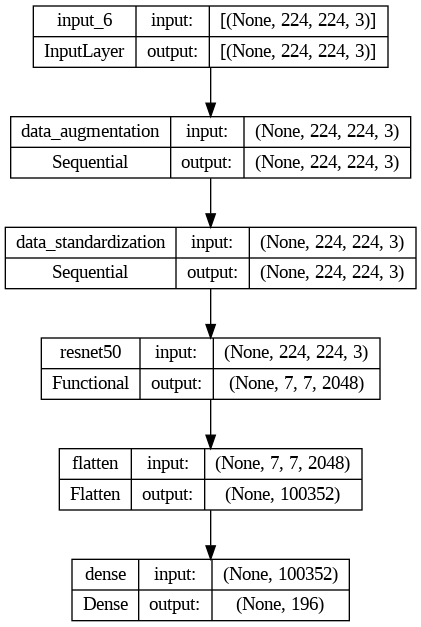

In [ ]:
# %%script echo skipped
exp1_model.summary()
tf.keras.utils.plot_model(exp1_model, to_file=f'{exp1_model.name}.png', show_shapes=True)

### Model Training

In [ ]:
exp1_history = exp1_model.fit(x=train_ds, validation_data=validation_ds, epochs=10,
                              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)])

Epoch 1/10
456/456 [==============================] - 214s 424ms/step - loss: 4.7182 - accuracy: 0.1613 - auc_2: 0.7524 - precision_2: 0.3883 - recall_2: 0.0980 - true_positives_2: 1428.0000 - true_negatives_2: 2838120.0000 - false_positives_2: 2250.0000 - false_negatives_2: 13138.0000 - val_loss: 0.7278 - val_accuracy: 0.8060 - val_auc_2: 0.9901 - val_precision_2: 0.9048 - val_recall_2: 0.7309 - val_true_positives_2: 2129.0000 - val_true_negatives_2: 567811.0000 - val_false_positives_2: 224.0000 - val_false_negatives_2: 784.0000
Epoch 2/10
456/456 [==============================] - 191s 416ms/step - loss: 0.4118 - accuracy: 0.9072 - auc_2: 0.9969 - precision_2: 0.9669 - recall_2: 0.8364 - true_positives_2: 12183.0000 - true_negatives_2: 2839953.0000 - false_positives_2: 417.0000 - false_negatives_2: 2383.0000 - val_loss: 0.0684 - val_accuracy: 0.9914 - val_auc_2: 0.9991 - val_precision_2: 0.9931 - val_recall_2: 0.9859 - val_true_positives_2: 2872.0000 - val_true_negatives_2: 568015.00

### Results and Evaluation Metrics

#### Visualization of all the metrics
plot the curves of all the metrics during training

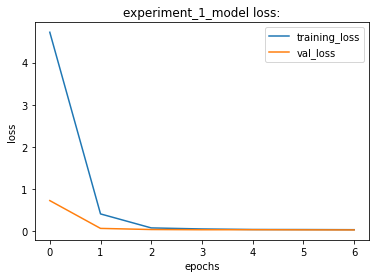

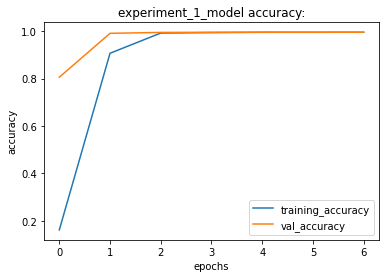

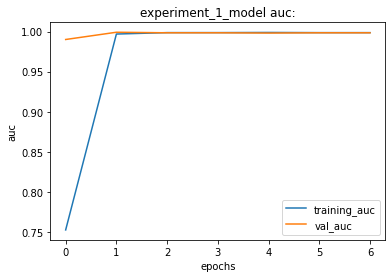

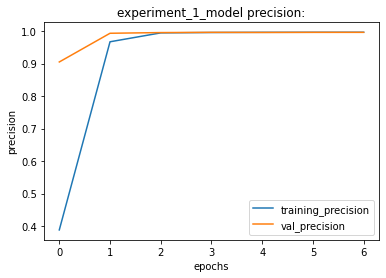

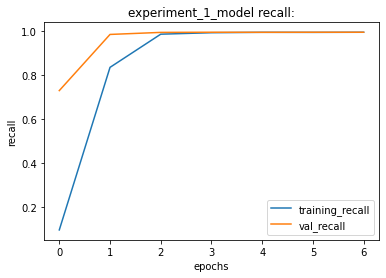

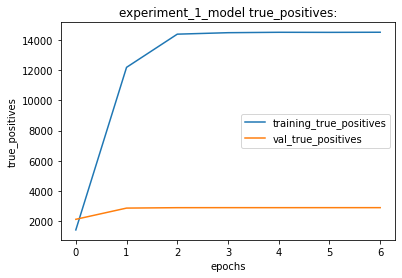

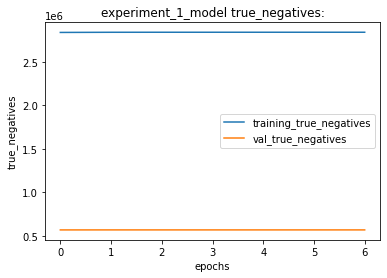

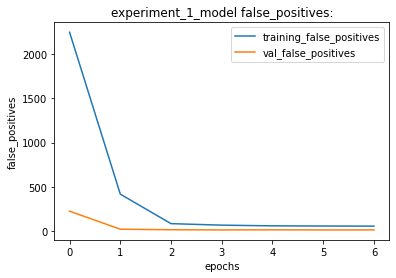

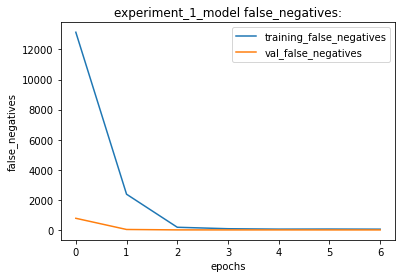

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_curves(exp1_model.name, exp1_history)

#### Model Performance Evaluation
evaluate the model performence on the test set

51/51 [==============================] - 28s 108ms/step - loss: 2.2896 - accuracy: 0.4688 - auc_2: 0.9257 - precision_2: 0.6979 - recall_2: 0.3768 - true_positives_2: 610.0000 - true_negatives_2: 315441.0000 - false_positives_2: 264.0000 - false_negatives_2: 1009.0000


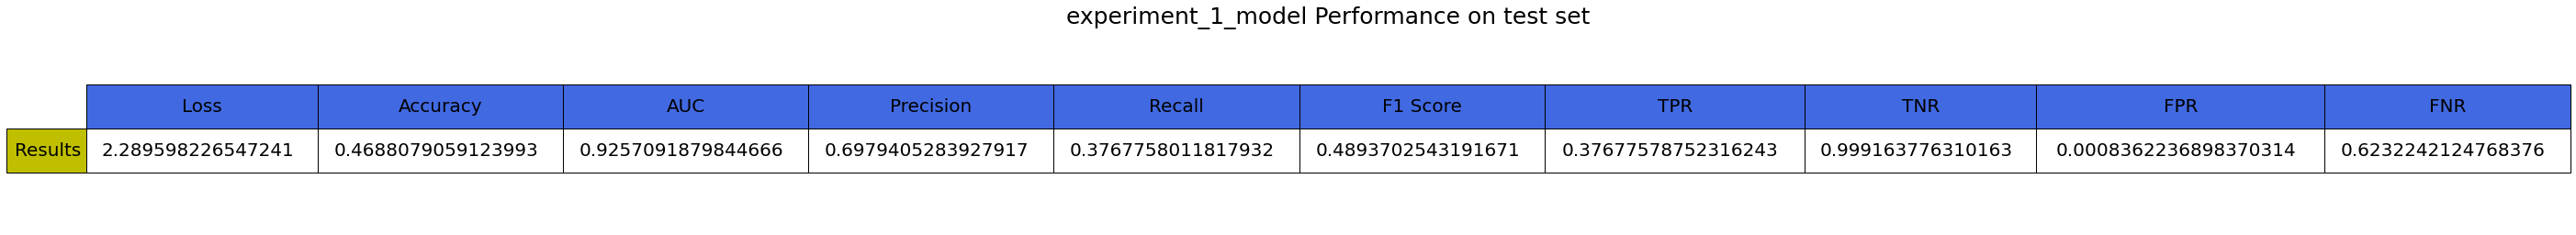

In [ ]:
evaluate_performence(exp1_model, test_ds)

## Experiment 2

### Model Building and Architecture

In [ ]:
import keras.backend as K

def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha*((1-p)^gamma)*log(p)
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
    """
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        # Clip the prediction value
        y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
        # Calculate cross entropy
        cross_entropy = -y_true*K.log(y_pred)
        # Calculate weight that consists of modulating factor and weighting factor
        weight = alpha * y_true * K.pow((1-y_pred), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.sum(loss, axis=1)
        return loss
    
    return focal_loss

In [ ]:
# ResNet50 with imagenet weights without the fully connected part on top.
exp2_resnet50 = tf.keras.applications.resnet50.ResNet50(weights="imagenet", input_shape=INPUT_SHAPE, include_top=False) 

# We want to train all the model weights except for the first 3 convolutional layers and all the batch norm layers
exp2_resnet50.trainable = True
for layer in exp2_resnet50.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Create the model
exp2_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(HEIGHT, WIDTH, 3)),
    data_augmentation,
    data_standardization,
    exp2_resnet50,

    # Add layers on top
    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(4096, use_bias=False),  # batch normalization eliminates the need for a bias vector
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(4096, use_bias=False),  # batch normalization eliminates the need for a bias vector
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(NUM_OF_CLASSES, activation='softmax')
], name='experiment_2_model')

# Compile the model
exp2_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=categorical_focal_loss(), metrics=METRICS)

#### Presentation of the architecture

Model: "experiment_2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 data_standardization (Seque  (None, 224, 224, 3)      0         
 ntial)                                                          
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 4096)              8388608   
                                                

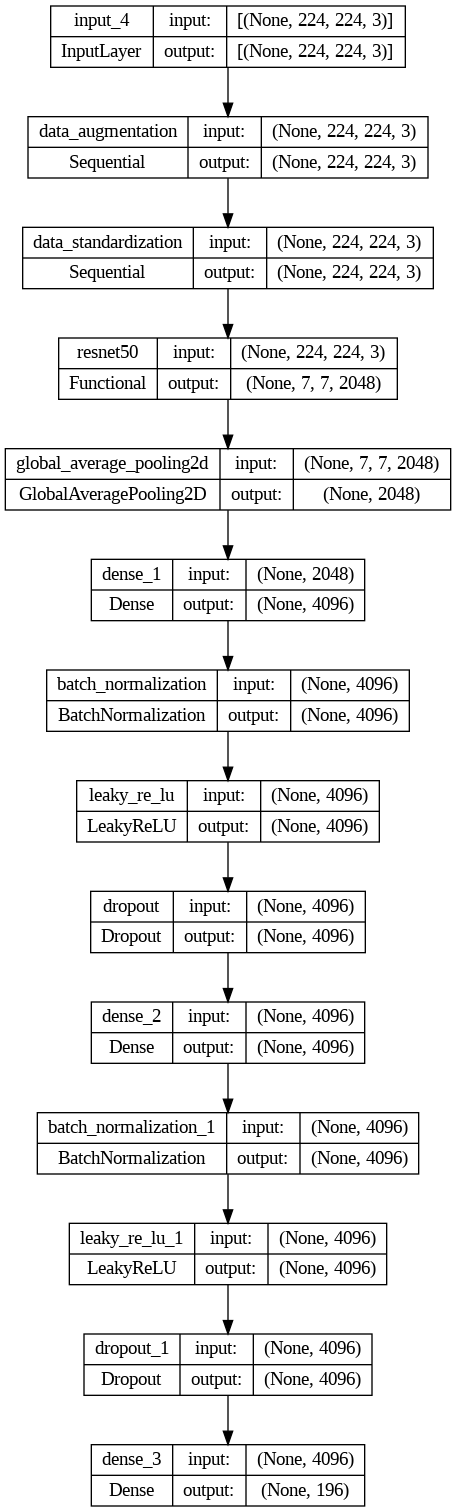

In [ ]:
# %%script echo skipped
exp2_model.summary()
tf.keras.utils.plot_model(exp2_model, to_file=f'{exp2_model.name}.png', show_shapes=True)

### Model Training

In [ ]:
# Fit the model with the train dataset and validate it with the validation dataset
exp2_history = exp2_model.fit(x=train_ds, validation_data=validation_ds, epochs=50,
                              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

Epoch 1/50
456/456 [==============================] - 213s 450ms/step - loss: 1.0358 - accuracy: 0.1155 - auc: 0.7230 - precision: 0.5798 - recall: 0.0100 - true_positives: 218.0000 - true_negatives: 4231732.0000 - false_positives: 158.0000 - false_negatives: 21484.0000 - val_loss: 0.5633 - val_accuracy: 0.3979 - val_auc: 0.9651 - val_precision: 0.8464 - val_recall: 0.0851 - val_true_positives: 248.0000 - val_true_negatives: 567990.0000 - val_false_positives: 45.0000 - val_false_negatives: 2665.0000
Epoch 2/50
456/456 [==============================] - 203s 443ms/step - loss: 0.5139 - accuracy: 0.4134 - auc: 0.9628 - precision: 0.8207 - recall: 0.1260 - true_positives: 1835.0000 - true_negatives: 2839969.0000 - false_positives: 401.0000 - false_negatives: 12731.0000 - val_loss: 0.2751 - val_accuracy: 0.6639 - val_auc: 0.9905 - val_precision: 0.9320 - val_recall: 0.2966 - val_true_positives: 864.0000 - val_true_negatives: 567972.0000 - val_false_positives: 63.0000 - val_false_negatives:

### Results and Evaluation Metrics

#### Visualization of all the metrics
plot the curves of all the metrics during training

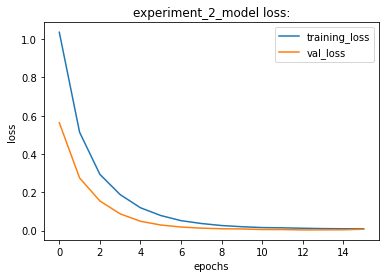

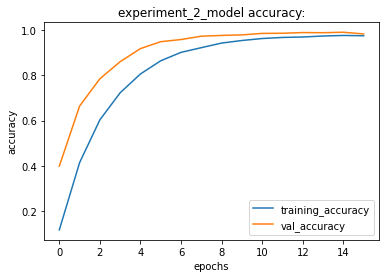

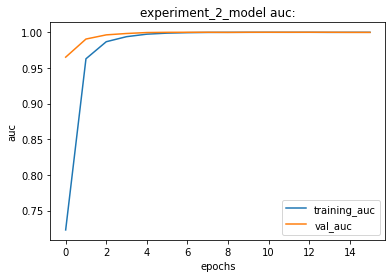

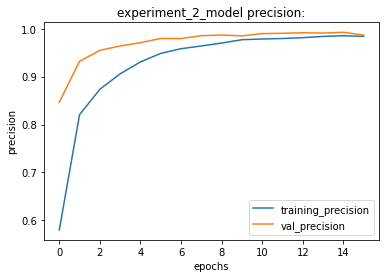

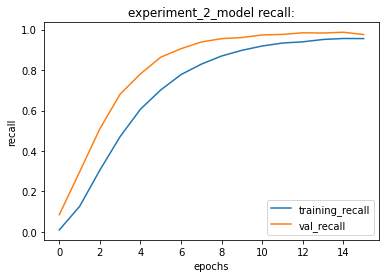

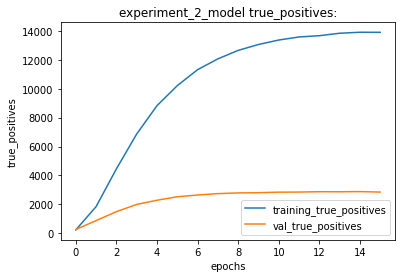

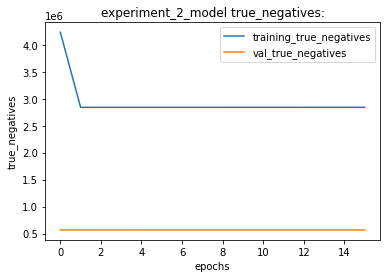

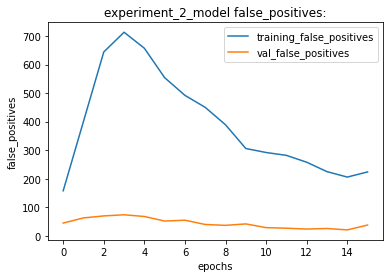

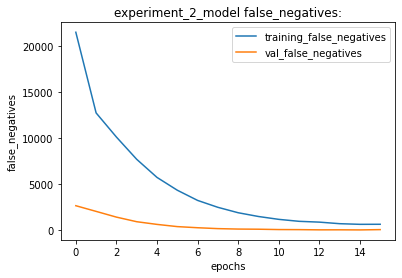

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_curves(exp2_model.name, exp2_history)

#### Model Performance Evaluation
evaluate the model performence on the test set

51/51 [==============================] - 28s 101ms/step - loss: 0.1380 - accuracy: 0.7888 - auc: 0.9919 - precision: 0.8912 - recall: 0.7029 - true_positives: 1138.0000 - true_negatives: 315566.0000 - false_positives: 139.0000 - false_negatives: 481.0000


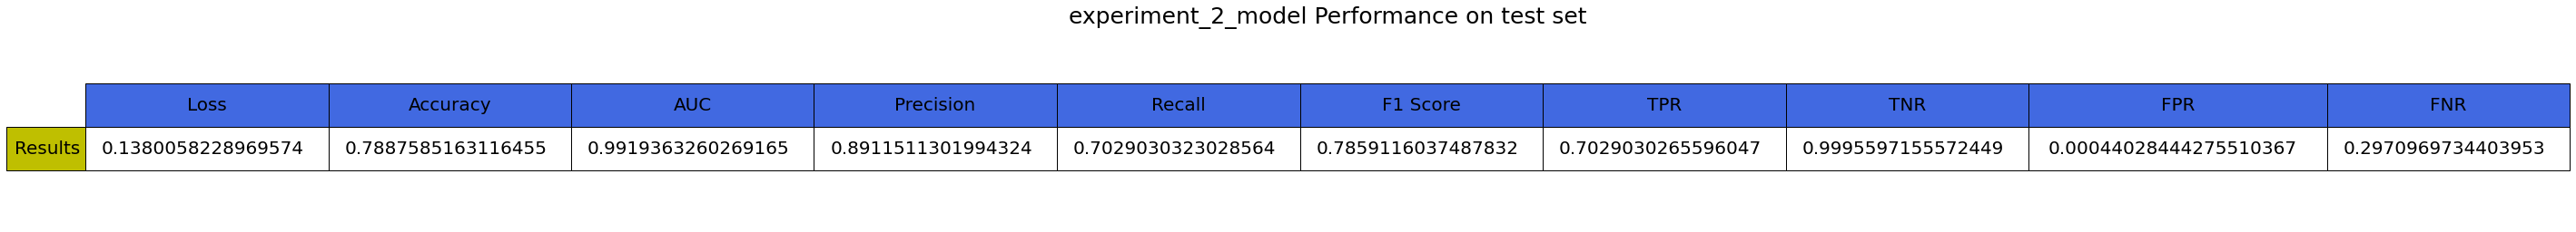

In [ ]:
evaluate_performence(exp2_model, test_ds)

## Experiment 3

### Model Building and Architecture

In [ ]:
# ResNet50 with imagenet weights without the fully connected part on top.
exp3_resnet50 = tf.keras.applications.resnet50.ResNet50(weights="imagenet", input_shape=INPUT_SHAPE, include_top=False) 

# We want to train all the model weights except for all the batch norm layers
exp3_resnet50.trainable = True
for layer in exp3_resnet50.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Create the model
exp3_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(HEIGHT, WIDTH, 3)),
    data_augmentation,
    data_standardization,
    exp3_resnet50,
    
    # Add layers on top
    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(4096, use_bias=False),  # batch normalization eliminates the need for a bias vector
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(4096, use_bias=False),  # batch normalization eliminates the need for a bias vector
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(NUM_OF_CLASSES, activation='softmax')
], name='experiment_3_model')

# Compile the model
exp3_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=METRICS)

#### Presentation of the architecture

Model: "experiment_3_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 data_standardization (Seque  (None, 224, 224, 3)      0         
 ntial)                                                          
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 4096)              8388608   
                                                

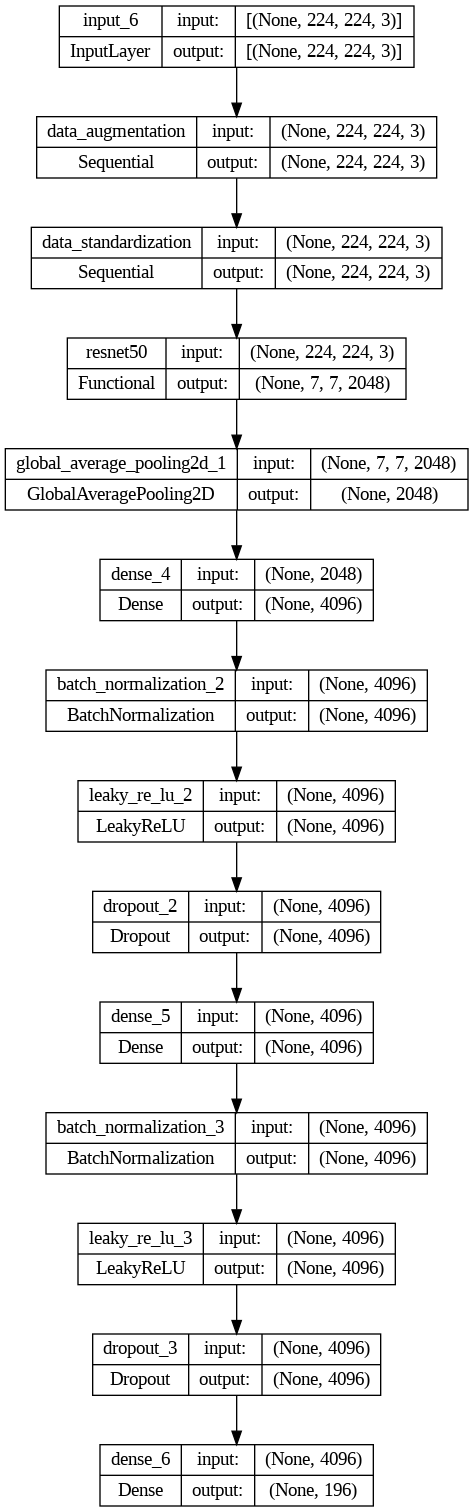

In [ ]:
# %%script echo skipped
exp3_model.summary()
tf.keras.utils.plot_model(exp3_model, to_file=f'{exp3_model.name}.png', show_shapes=True)

### Model Training

In [ ]:
# Fit the model with the train dataset and validate it with the validation dataset
exp3_history = exp3_model.fit(x=train_ds, validation_data=validation_ds, epochs=50,
                              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, restore_best_weights=True)])

Epoch 1/50
456/456 [==============================] - 228s 464ms/step - loss: 4.4153 - accuracy: 0.1033 - auc_1: 0.7697 - precision_1: 0.5305 - recall_1: 0.0113 - true_positives_1: 165.0000 - true_negatives_1: 2840224.0000 - false_positives_1: 146.0000 - false_negatives_1: 14401.0000 - val_loss: 2.6659 - val_accuracy: 0.3814 - val_auc_1: 0.9631 - val_precision_1: 0.8114 - val_recall_1: 0.0827 - val_true_positives_1: 241.0000 - val_true_negatives_1: 567979.0000 - val_false_positives_1: 56.0000 - val_false_negatives_1: 2672.0000
Epoch 2/50
456/456 [==============================] - 211s 460ms/step - loss: 2.4941 - accuracy: 0.3916 - auc_1: 0.9604 - precision_1: 0.7844 - recall_1: 0.1226 - true_positives_1: 1786.0000 - true_negatives_1: 2839879.0000 - false_positives_1: 491.0000 - false_negatives_1: 12780.0000 - val_loss: 1.4753 - val_accuracy: 0.6595 - val_auc_1: 0.9901 - val_precision_1: 0.9229 - val_recall_1: 0.3368 - val_true_positives_1: 981.0000 - val_true_negatives_1: 567953.0000 -

### Results and Evaluation Metrics

#### Visualization of all the metrics
plot the curves of all the metrics during training

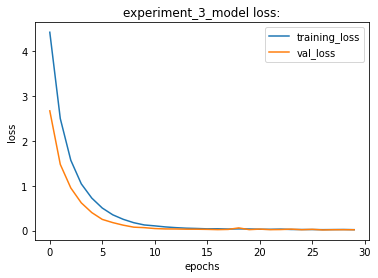

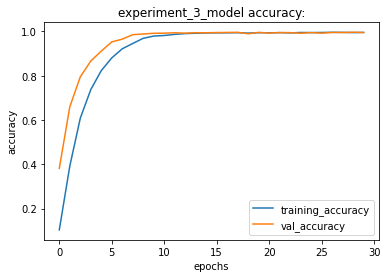

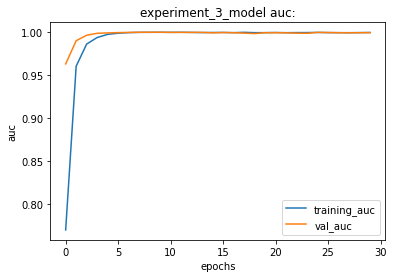

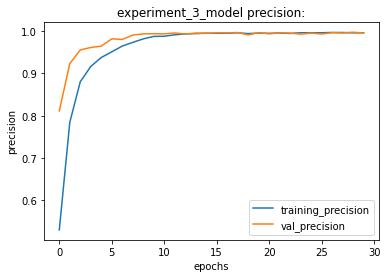

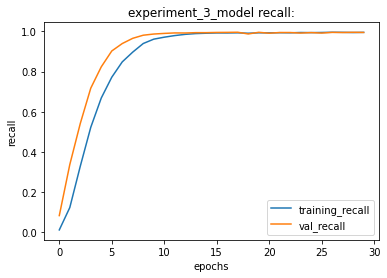

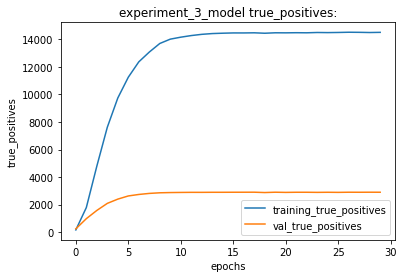

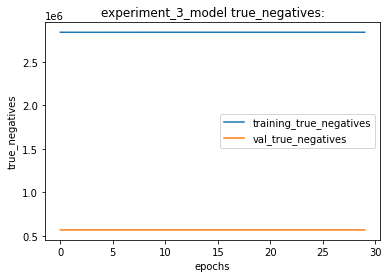

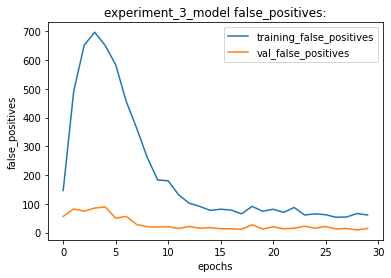

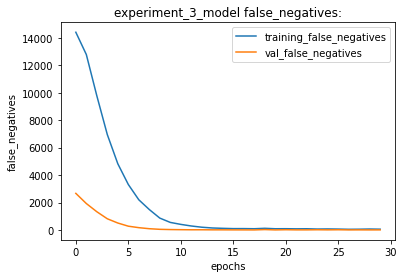

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_curves(exp3_model.name, exp3_history)

#### Model Performance Evaluation
evaluate the model performence on the test set

51/51 [==============================] - 28s 96ms/step - loss: 0.6927 - accuracy: 0.8363 - auc_1: 0.9813 - precision_1: 0.8787 - recall_1: 0.8054 - true_positives_1: 1304.0000 - true_negatives_1: 315525.0000 - false_positives_1: 180.0000 - false_negatives_1: 315.0000


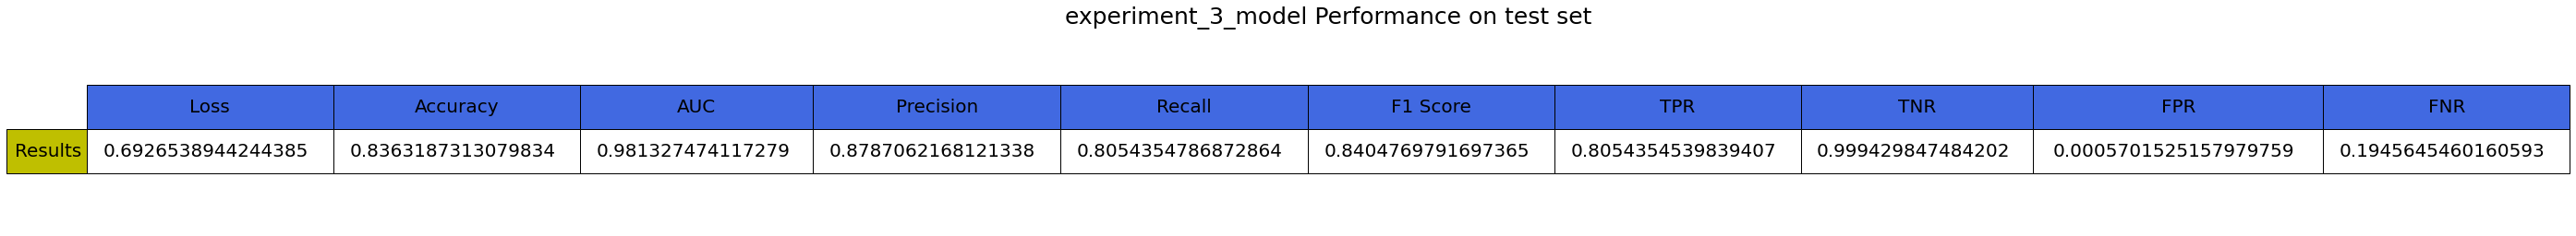

In [ ]:
evaluate_performence(exp3_model, test_ds)

### Save Trained model

In [ ]:
%%script echo skipped
drive.mount('/content/drive')
exp3_model.save('/content/drive/MyDrive/Colab Notebooks/final_project_basics_2023/transfer_model_exp3.h5')

# (2) Image Retrieval

### Data Preprocessing


#### Data Transformation for all the experiments
We will use the same data transformation for all the 3 experiments.

We will use the data transformation that made in the section "Data Preprocessing for the whole project" (at the begining).

#### Data Augmentation for all the experiments
We will **NOT** do any data augmentation for all the 3 experiments.

#### Data Standardization for all the experiments
We will use the same data standardization for all the 3 experiments.
Data Standardization is done at the embedding model with the standardization layer. (It's best practice to add all the pre-processing steps as layers in the model itself because at inferece the pre-processing is done at the model itself)

## Embedding model for all the experiments
We will use the embedding layer of our best transfer learning model (experiment 3 model) from part 1

#### Embedding model architecture
Note that the data standardization is done inside the model itself as a layer

In [ ]:
embedding_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(HEIGHT, WIDTH, 3)),
    data_standardization,
    exp3_resnet50,
    tf.keras.layers.GlobalAveragePooling2D()
], name='image_retrieval_embedding_model')

#### Create the embeddings for the KNN models using the embedding model
Creating the embeddings for the train set + validation set and test set

In [ ]:
# concatenate the train and validation set
KNN_train_ds = train_ds.concatenate(validation_ds)

# Extract the embeddings for the train set
train_embeddings, Y_train = extract_dataset_embeddings(embedding_model, KNN_train_ds)

# Extract the embeddings for the test set
test_embeddings, Y_test = extract_dataset_embeddings(embedding_model, test_ds)
Y_test = np.argmax(Y_test, axis=1)

#### Presentation of the embedding model architecture

In [ ]:
# %%script echo skipped
embedding_model.summary()
tf.keras.utils.plot_model(embedding_model, to_file=f'{embedding_model.name}.png', show_shapes=True)

#### Save the embedding model
We'll save the embedding model and build the KNN model with the K hyperparameter of experiment 3 (our best image retrieval model) later on the test environment

In [ ]:
%%script echo skipped
drive.mount('/content/drive')
embedding_model.save('/content/drive/MyDrive/Colab Notebooks/final_project_basics_2023/embedding_model_image_retrieval.h5')

## Experiment 1

### Model Building and Architecture

In [ ]:
k = 2
exp1_kNeighbors = KNeighborsClassifier(k)

# Fit the embeddings to the nearest neighbors model
exp1_kNeighbors.fit(train_embeddings, Y_train)

### Model Performance Evaluation
evaluate the model performence on the test set

In [ ]:
exp1_preds = exp1_kNeighbors.predict(test_embeddings)

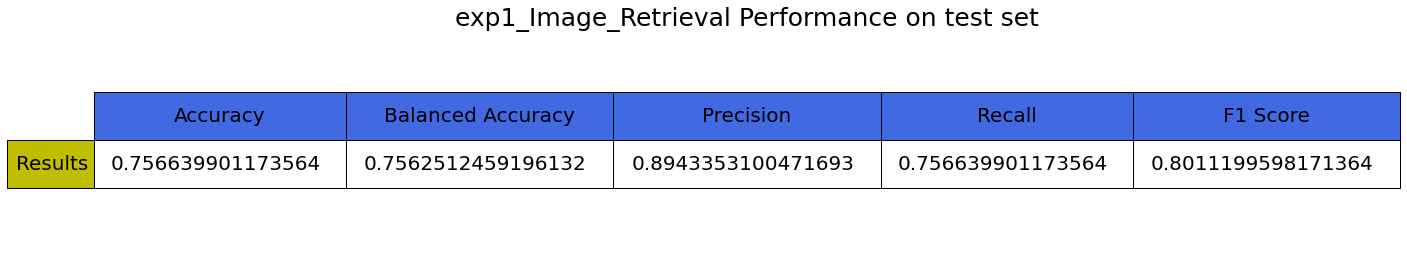

In [ ]:
eval_perf(Y_test, np.argmax(exp1_preds, axis=1), name='exp1_Image_Retrieval')

## Experiment 2

### Model Building and Architecture

In [ ]:
k = 4
exp2_kNeighbors = KNeighborsClassifier(k)

# Fit the embeddings to the nearest neighbors model
exp2_kNeighbors.fit(train_embeddings, Y_train)

### Model Performance Evaluation
evaluate the model performence on the test set

In [ ]:
exp2_preds = exp2_kNeighbors.predict(test_embeddings)

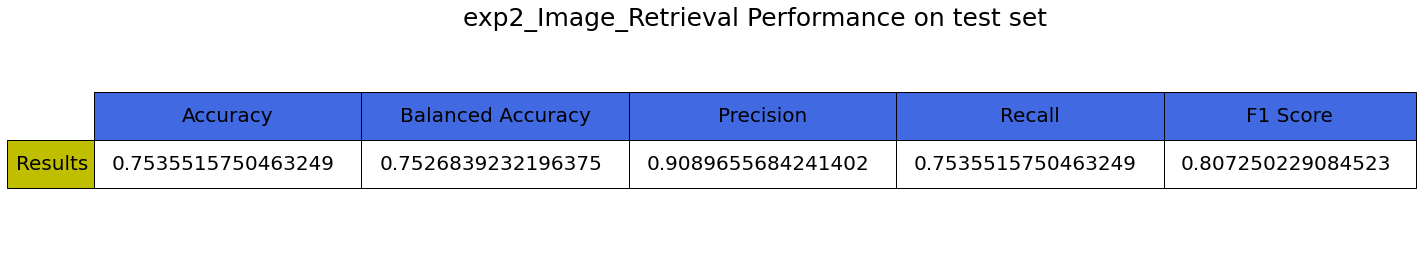

In [ ]:
eval_perf(Y_test, np.argmax(exp2_preds, axis=1), name='exp2_Image_Retrieval')

## Experiment 3

### Model Building and Architecture

In [ ]:
k = 3
exp3_kNeighbors = KNeighborsClassifier(k)

# Fit the embeddings to the nearest neighbors model
exp3_kNeighbors.fit(train_embeddings, Y_train)

### Model Performance Evaluation
evaluate the model performence on the test set

In [ ]:
exp3_preds = exp3_kNeighbors.predict(test_embeddings)

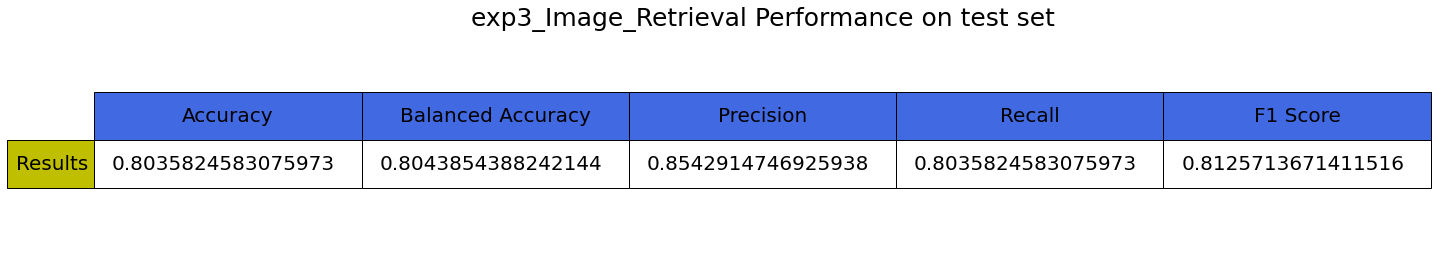

In [ ]:
eval_perf(Y_test, np.argmax(exp3_preds, axis=1), name='exp3_Image_Retrieval')

### Saving KNN model

In [ ]:
%%script echo skipped
joblib.dump(exp3_kNeighbors, '/content/drive/MyDrive/Colab Notebooks/final_project_basics_2023/exp3_KNN.pkl')

# (3) End-to-End CNN

## Experiment 1

### Data Preprocessing

#### Data Transformation
We will use the data transformation that made in the section "Data Preprocessing for the whole project" (at the begining).

#### Data Augmentation
We will use the data augmentation that made in the section "Data Preprocessing for the whole project" (at the begining).

#### Data Standardization

In [ ]:
data_standardization = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.keras.applications.resnet50.preprocess_input(x), name="resnet50_preprocess_layer")
], name='data_standardization')

### Model Building and Architecture

In [ ]:
def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    X = tf.keras.layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = tf.keras.layers.Activation('relu')(X)

    X = tf.keras.layers.Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = tf.keras.layers.Activation('relu')(X)

    X = tf.keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = tf.keras.layers.Add()([X, X_shortcut]) # SKIP Connection
    X = tf.keras.layers.Activation('relu')(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = tf.keras.layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = tf.keras.layers.Activation('relu')(X)

    X = tf.keras.layers.Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = tf.keras.layers.Activation('relu')(X)

    X = tf.keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = tf.keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0))(X_shortcut)
    X_shortcut = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)

    return X

In [ ]:
def ResNet50(input_shape=INPUT_SHAPE):
    X_input = tf.keras.layers.Input(input_shape)

    X = tf.keras.layers.ZeroPadding2D((3, 3))(X_input)

    X = tf.keras.layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis=3, name='bn_conv1')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    model = tf.keras.models.Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [ ]:
exp1_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE),
    data_augmentation,
    data_standardization,
    ResNet50(input_shape=INPUT_SHAPE),

    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(4096, use_bias=False, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(4096, use_bias=False, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(units=NUM_OF_CLASSES, activation="softmax"),
], name='experiment_1_model')

In [ ]:
exp1_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=tf.keras.losses.categorical_crossentropy, metrics=METRICS)

#### Presentation of the architecture

Model: "experiment_1_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 data_standardization (Seque  (None, 224, 224, 3)      0         
 ntial)                                                          
                                                                 
 ResNet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 4096)              8388608   
                                                

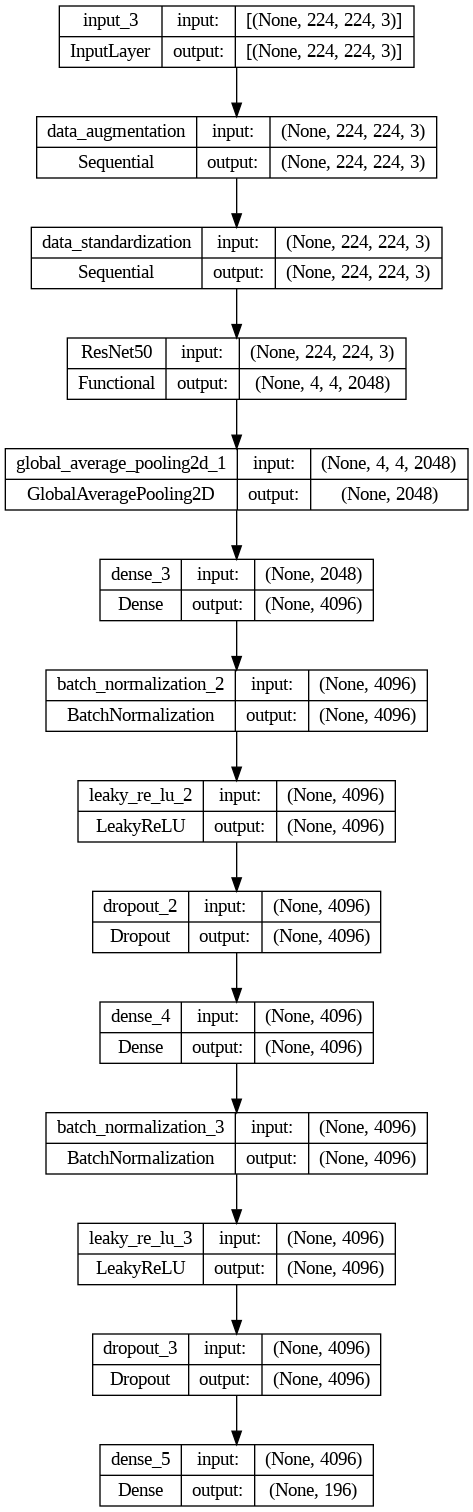

In [ ]:
# %%script echo skipped
exp1_model.summary()
tf.keras.utils.plot_model(exp1_model, to_file=f'{exp1_model.name}.png', show_shapes=True)

### Model Training

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
mc = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/final_project_basics_2023/best_weights_cnn_end_to_end.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

exp1_history = exp1_model.fit(x=train_ds, validation_data=validation_ds, epochs=100, callbacks=[mc, es])

Epoch 1/100
456/456 [==============================] - ETA: 0s - loss: 5.7008 - accuracy: 0.0076 - auc_1: 0.5209 - precision_1: 0.0122 - recall_1: 1.3731e-04 - true_positives_1: 2.0000 - true_negatives_1: 2840208.0000 - false_positives_1: 162.0000 - false_negatives_1: 14564.0000
Epoch 1: val_accuracy improved from -inf to 0.00858, saving model to /content/drive/MyDrive/Colab Notebooks/final_project_basics_2023/best_weights_cnn_end_to_end.h5
456/456 [==============================] - 113s 134ms/step - loss: 5.7008 - accuracy: 0.0076 - auc_1: 0.5209 - precision_1: 0.0122 - recall_1: 1.3731e-04 - true_positives_1: 2.0000 - true_negatives_1: 2840208.0000 - false_positives_1: 162.0000 - false_negatives_1: 14564.0000 - val_loss: 5.3701 - val_accuracy: 0.0086 - val_auc_1: 0.5517 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_true_positives_1: 0.0000e+00 - val_true_negatives_1: 568006.0000 - val_false_positives_1: 29.0000 - val_false_negatives_1: 2913.0000
Epoch 2/100
456/456 [

### Results and Evaluation Metrics

#### Visualization of all the metrics
plot the curves of all the metrics during training

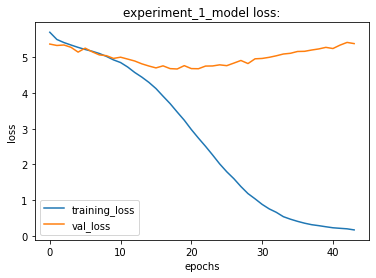

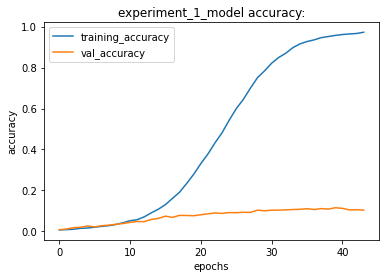

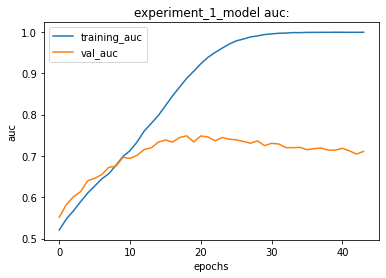

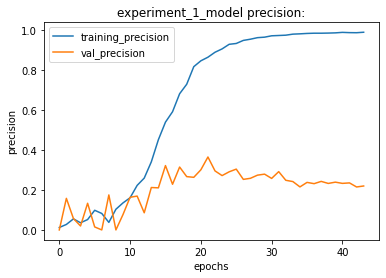

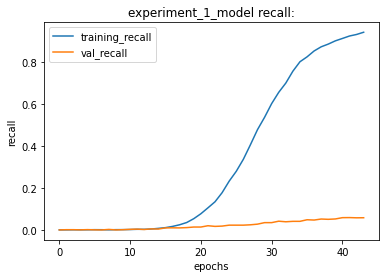

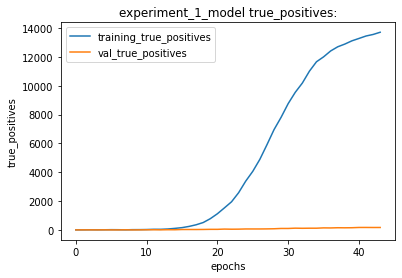

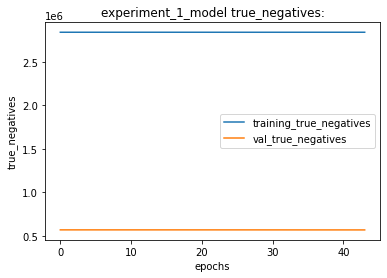

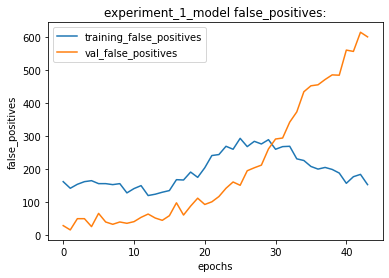

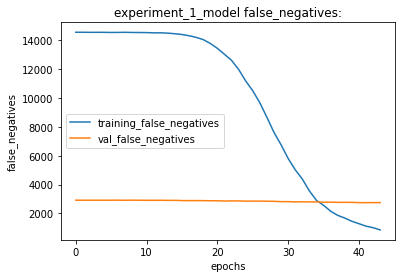

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_curves(exp1_model.name, exp1_history)

#### Model Performance Evaluation
evaluate the model performence on the test set

51/51 [==============================] - 17s 33ms/step - loss: 6.6786 - accuracy: 0.0346 - auc_1: 0.6076 - precision_1: 0.0815 - recall_1: 0.0161 - true_positives_1: 26.0000 - true_negatives_1: 315412.0000 - false_positives_1: 293.0000 - false_negatives_1: 1593.0000


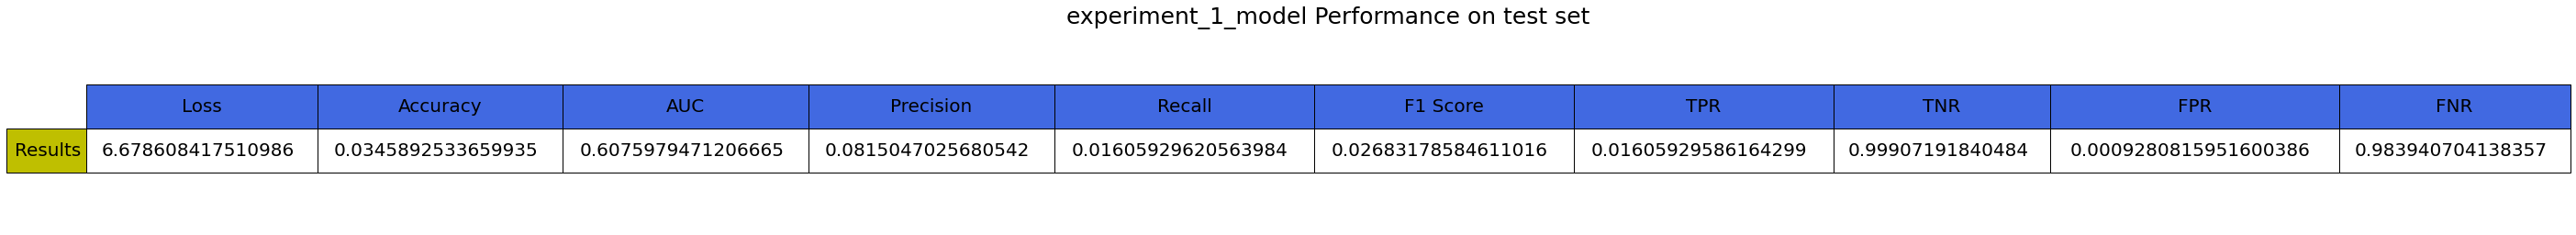

In [ ]:
evaluate_performence(exp1_model, test_ds)

## Experiment 2

### Data Preprocessing

#### Data Transformation
We will use the data transformation that made in the section "Data Preprocessing for the whole project" (at the begining).

#### Data Augmentation
We will use the data augmentation that made in the section "Data Preprocessing for the whole project" (at the begining).

#### Data Standardization


In [ ]:
data_standardization = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.keras.applications.vgg16.preprocess_input(x), name="vgg16_preprocess_layer")
], name='data_standardization')

### Model Building and Architecture

In [ ]:
exp2_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(HEIGHT, WIDTH, 3)),
    data_augmentation,
    data_standardization,
    
    tf.keras.layers.Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    
    tf.keras.layers.GlobalAveragePooling2D(),
    
    tf.keras.layers.Dense(4096, use_bias=False),  # batch normalization eliminates the need for a bias vector
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(4096, use_bias=False),  # batch normalization eliminates the need for a bias vector
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(units=NUM_OF_CLASSES, activation="softmax")
])

In [ ]:
exp2_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=tf.keras.losses.categorical_crossentropy, metrics=METRICS)

#### Presentation of the architecture

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 data_standardization (Seque  (None, 224, 224, 3)      0         
 ntial)                                                          
                                                                 
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                      

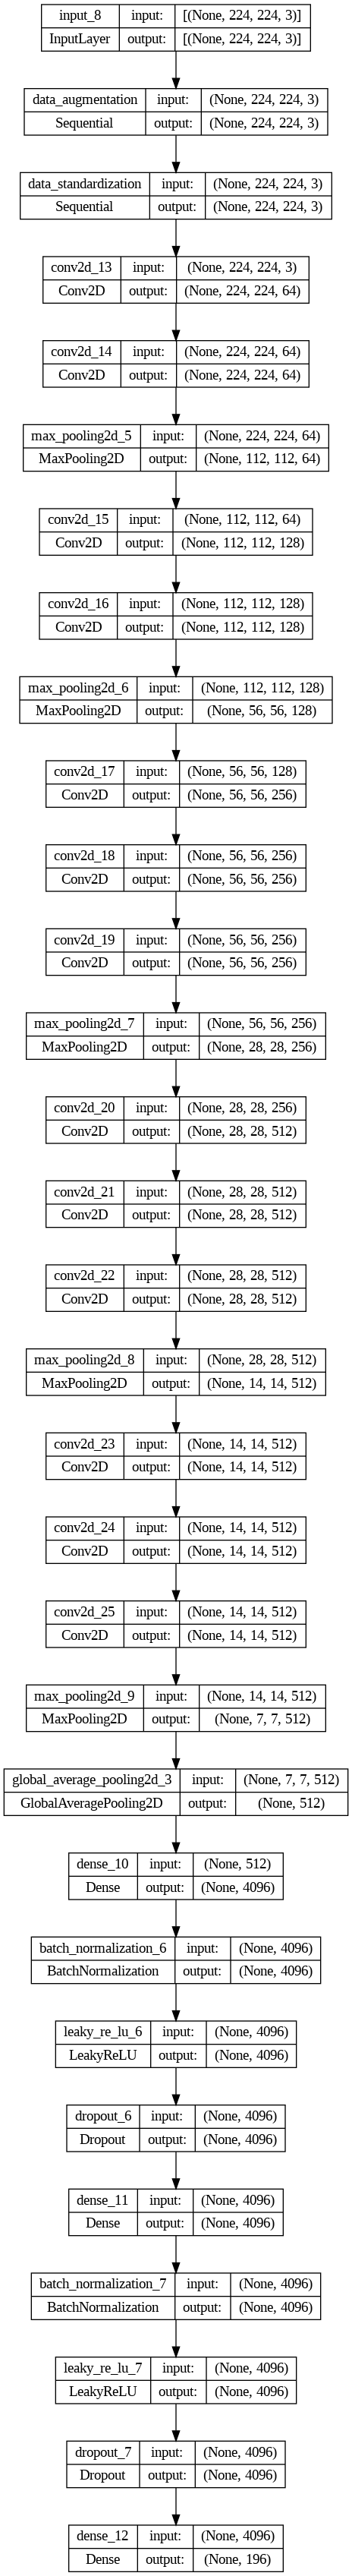

In [ ]:
# %%script echo skipped
exp2_model.summary()
tf.keras.utils.plot_model(exp2_model, to_file=f'{exp2_model.name}.png', show_shapes=True)

### Model Training

In [ ]:
exp2_history = exp2_model.fit(x=train_ds, validation_data=validation_ds, epochs=50,
                              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, restore_best_weights=True)])

Epoch 1/50
456/456 [==============================] - 59s 112ms/step - loss: 5.6389 - accuracy: 0.0102 - auc: 0.5521 - precision: 0.0909 - recall: 6.2933e-04 - true_positives: 11.0000 - true_negatives: 3408295.0000 - false_positives: 110.0000 - false_negatives: 17468.0000 - val_loss: 5.3149 - val_accuracy: 0.0110 - val_auc: 0.5597 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_true_negatives: 568035.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 2913.0000
Epoch 2/50
456/456 [==============================] - 51s 110ms/step - loss: 5.3858 - accuracy: 0.0143 - auc: 0.5897 - precision: 0.0533 - recall: 5.4922e-04 - true_positives: 8.0000 - true_negatives: 2840228.0000 - false_positives: 142.0000 - false_negatives: 14558.0000 - val_loss: 5.5908 - val_accuracy: 0.0113 - val_auc: 0.5775 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_true_negatives: 568005.0000 - val_false_positives: 30.00

### Results and Evaluation Metrics

#### Visualization of all the metrics
plot the curves of all the metrics during training

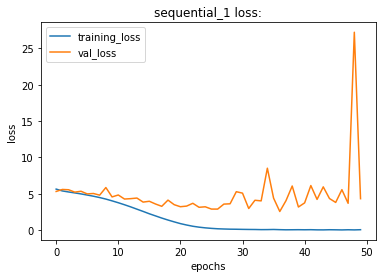

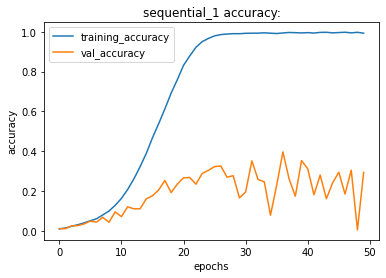

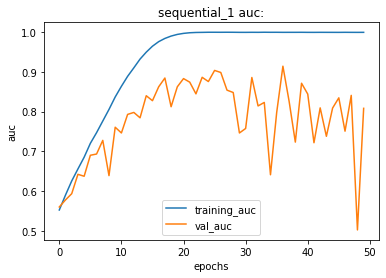

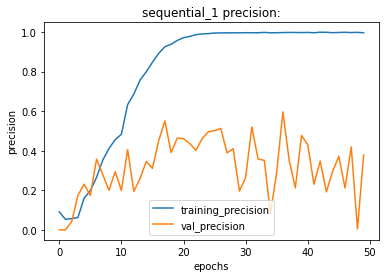

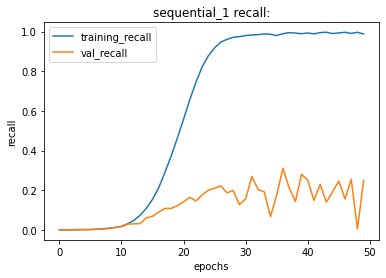

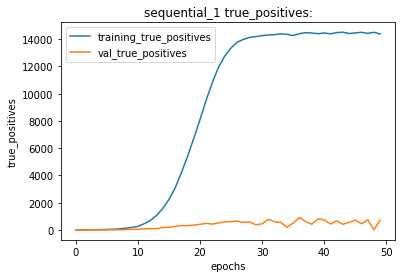

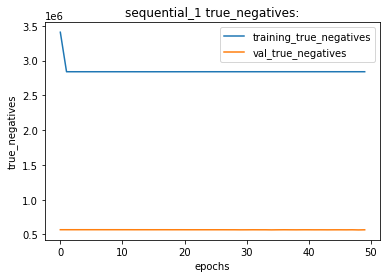

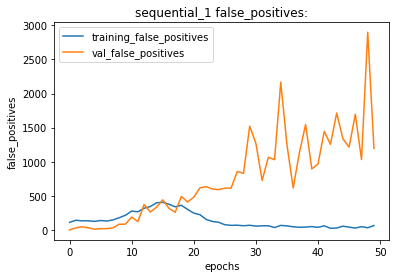

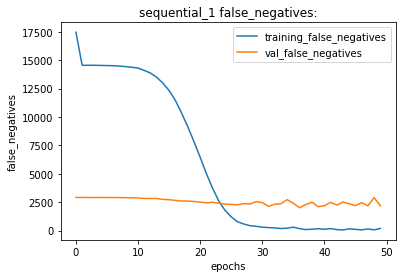

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_curves(exp2_model.name, exp2_history)

#### Model Performance Evaluation
evaluate the model performence on the test set

51/51 [==============================] - 17s 34ms/step - loss: 6.4013 - accuracy: 0.1538 - auc: 0.7003 - precision: 0.2014 - recall: 0.1272 - true_positives: 206.0000 - true_negatives: 314888.0000 - false_positives: 817.0000 - false_negatives: 1413.0000


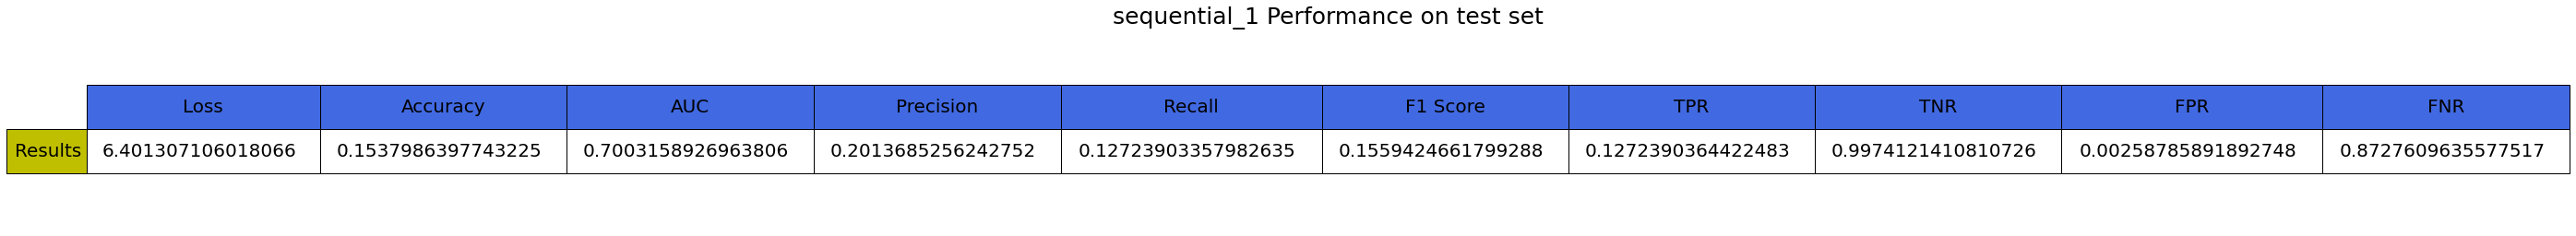

In [ ]:
evaluate_performence(exp2_model, test_ds)

## Experiment 3

### Data Preprocessing

#### Data Transformation
We will use the data transformation that made in the section "Data Preprocessing for the whole project" (at the begining).

#### Data Augmentation
We will use the data augmentation that made in the section "Data Preprocessing for the whole project" (at the begining).

#### Data Standardization


In [ ]:
data_standardization = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.keras.applications.vgg16.preprocess_input(x), name="vgg16_preprocess_layer")
], name='data_standardization')

### Model Building and Architecture

In [ ]:
exp3_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE),
    data_augmentation,
    data_standardization,

    tf.keras.layers.Conv2D(32, (3,3), kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.MaxPooling2D((2,2)),
    
    tf.keras.layers.Conv2D(64, (3,3), kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.MaxPooling2D((2,2)),
    
    tf.keras.layers.Conv2D(128, (3,3), kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.MaxPooling2D((2,2)),
    
    tf.keras.layers.Conv2D(256, (3,3), kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.MaxPooling2D((2,2)),
    
    tf.keras.layers.Conv2D(512, (3,3), kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.MaxPooling2D((2,2)),
    
    tf.keras.layers.Conv2D(1024, (3,3), kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.MaxPooling2D((2,2)),
    
    tf.keras.layers.GlobalAveragePooling2D(),
    
    tf.keras.layers.Dense(2048, use_bias=False, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    
    tf.keras.layers.Dense(2048, use_bias=False, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    
    tf.keras.layers.Dense(512, use_bias=False, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    
    tf.keras.layers.Dense(256, use_bias=False, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    
    tf.keras.layers.Dense(128, use_bias=False, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    
    tf.keras.layers.Dense(NUM_OF_CLASSES, activation='softmax'),
], name='experiment_3_model')

In [ ]:
exp3_model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss=tf.keras.losses.categorical_crossentropy, metrics=METRICS)

#### Presentation of the architecture

Model: "experiment_3_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 data_standardization (Seque  (None, 224, 224, 3)      0         
 ntial)                                                          
                                                                 
 conv2d_26 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 222, 222, 32)      0         
                                                

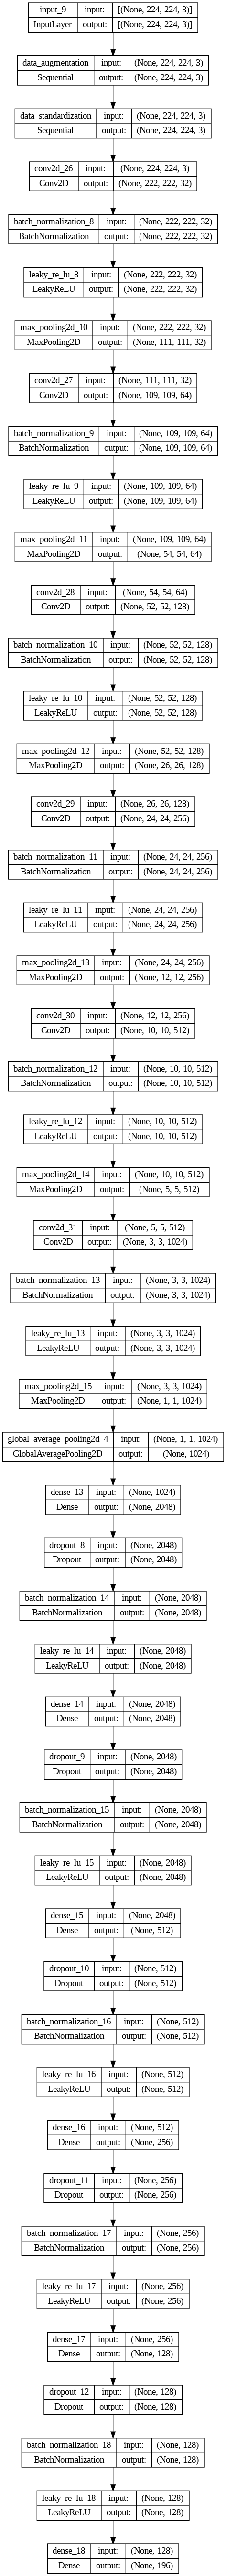

In [ ]:
# %%script echo skipped
exp3_model.summary()
tf.keras.utils.plot_model(exp3_model, to_file=f'{exp3_model.name}.png', show_shapes=True)

### Model Training

**Note:** model is saved to drive using tf.keras.callbacks.ModelCheckpoint

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True)
mc = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/final_project_basics_2023/exp3_best_weights_cnn_end_to_end.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

exp3_history = exp3_model.fit(x=train_ds, validation_data=validation_ds, epochs=250, callbacks=[mc, es])

Epoch 1/250
456/456 [==============================] - ETA: 0s - loss: 5.3120 - accuracy: 0.0073 - auc: 0.5235 - precision: 0.0000e+00 - recall: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 2840367.0000 - false_positives: 3.0000 - false_negatives: 14566.0000
Epoch 1: val_accuracy improved from -inf to 0.00893, saving model to /content/drive/MyDrive/Colab Notebooks/final_project_basics_2023/exp3_best_weights_cnn_end_to_end.h5
456/456 [==============================] - 60s 85ms/step - loss: 5.3120 - accuracy: 0.0073 - auc: 0.5235 - precision: 0.0000e+00 - recall: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 2840367.0000 - false_positives: 3.0000 - false_negatives: 14566.0000 - val_loss: 6.2777 - val_accuracy: 0.0089 - val_auc: 0.5077 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_true_negatives: 568025.0000 - val_false_positives: 10.0000 - val_false_negatives: 2913.0000
Epoch 2/250
455/456 [===========================

### Results and Evaluation Metrics

#### Visualization of all the metrics
plot the curves of all the metrics during training

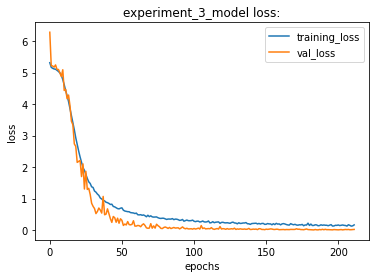

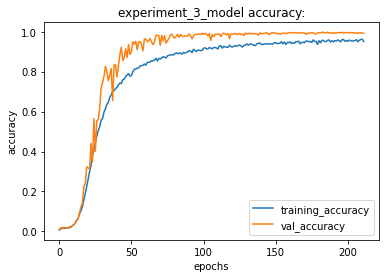

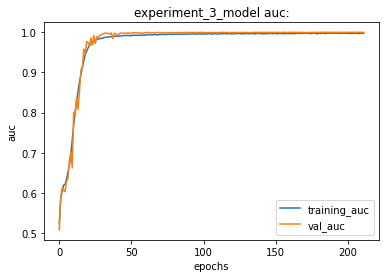

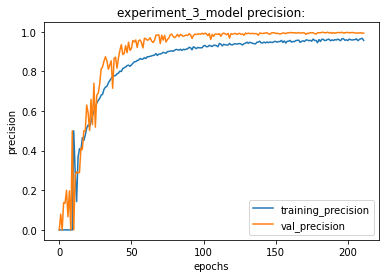

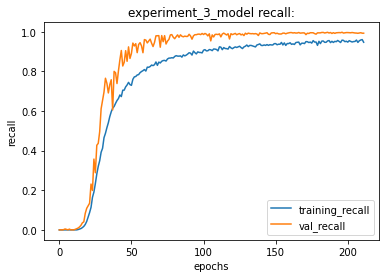

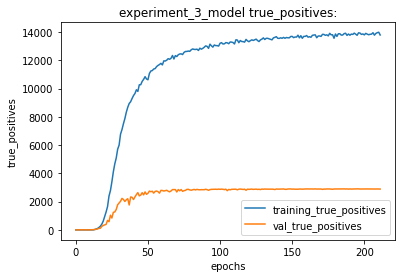

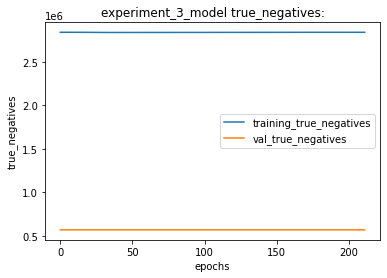

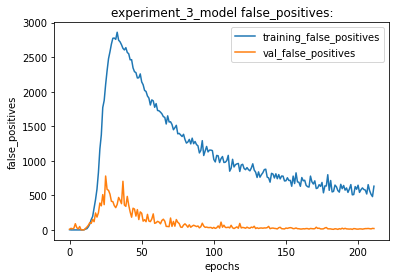

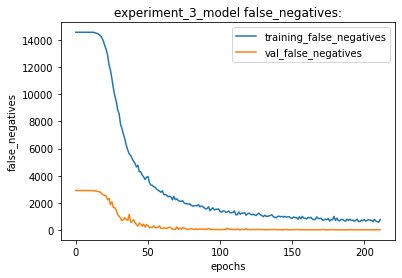

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_curves(exp3_model.name, exp3_history)

#### Model Performance Evaluation
evaluate the model performence on the test set

51/51 [==============================] - 17s 30ms/step - loss: 7.0711 - accuracy: 0.2452 - auc: 0.7352 - precision: 0.2971 - recall: 0.2279 - true_positives: 369.0000 - true_negatives: 314832.0000 - false_positives: 873.0000 - false_negatives: 1250.0000


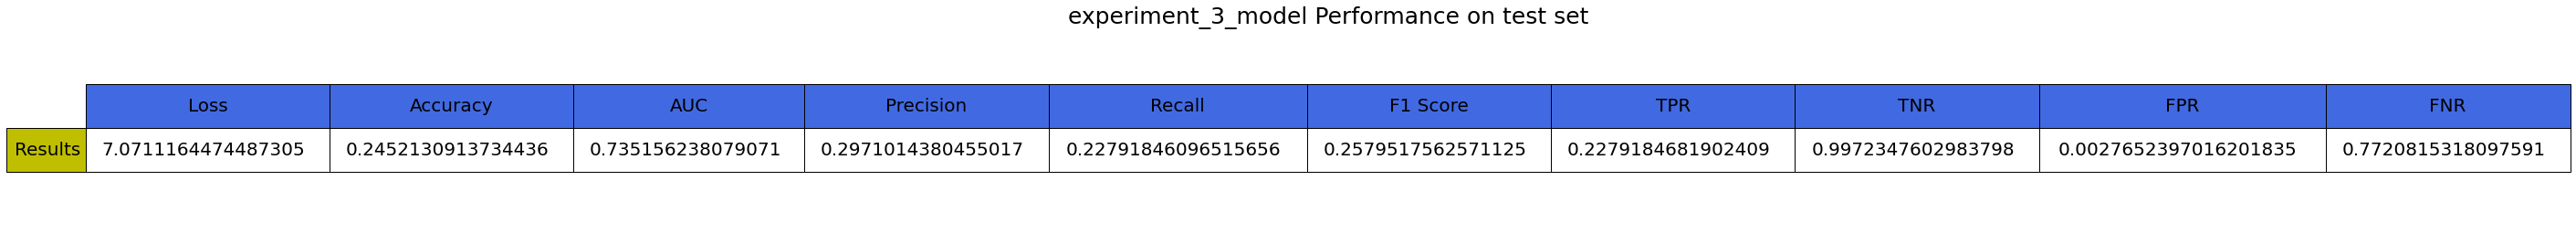

In [ ]:
evaluate_performence(exp3_model, test_ds)

# Test Environment

### Import necessery libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import joblib
import tensorflow_datasets as tfds
from sklearn.neighbors import KNeighborsClassifier

## Load Models
Loading the following models:
1. Transfer Learning model
2. Image Retrieval model
2. End-to-End CNN model

### Downloading saved models

In [2]:
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1TPc4CJ1W_NoF24TI1tQtMHRXMM4Yps6u
!unzip /content/my_files.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1TPc4CJ1W_NoF24TI1tQtMHRXMM4Yps6u
To: /content/my_files.zip
100% 927M/927M [00:04<00:00, 197MB/s]
Archive:  /content/my_files.zip
  inflating: cnn_end_to_end_exp3.h5  
  inflating: __MACOSX/._cnn_end_to_end_exp3.h5  
  inflating: embedding_model_image_retrieval.h5  
  inflating: __MACOSX/._embedding_model_image_retrieval.h5  
  inflating: exp3_KNN.pkl            
  inflating: __MACOSX/._exp3_KNN.pkl  
  inflating: explainer.md            
  inflating: __MACOSX/._explainer.md  
  in

Dictionary of the labels - maps between the label (int) number and the vehicle model (str)

In [3]:
label_dic = pd.read_csv('/content/labels_dic.csv', header=None, dtype={0: str}).set_index(0).squeeze().to_dict()

### Loading the Transfer Learning model

In [4]:
tl_model = tf.keras.models.load_model('/content/transfer_model_exp3.h5')

### Loading the Image Retrieval model
Loading the embedding model and KNN model of the Image Retrieval part

In [5]:
def transform(x, y):
    x = tf.image.resize(x, (224, 224))  # resizing
    x = tf.cast(x, tf.float32)  # casing to float32
    y = tf.one_hot(y, depth=196)  # changing labels from sparse to one-hot-encoding
    return x, y

In [6]:
def extract_dataset_embeddings(embedding_model, dataset): # Extract embeddings for a set of samples
    embeddings = []
    labels = []
    for batch, batch_labels in dataset:
        batch_embeddings = embedding_model.predict(batch)
        embeddings.append(batch_embeddings)
        labels.append(batch_labels)
    return np.concatenate(embeddings), np.concatenate(labels)

***Please Read This:***

**Note that we thought about loading the model from a pkl file but bugs started to pop up so we loaded it from scratch.**

We loaded the same KNN model as in experiment 3 section of the image retrieval section (just now we used all the dataset for the test environment because it is a KNN model and it will be a waste to only use the train set)

In [7]:
embedding_model = tf.keras.models.load_model('/content/embedding_model_image_retrieval.h5')
# kNeighbors = joblib.load('/content/exp3_KNN.pkl' , mmap_mode ='r') ### We thought about loading the model from a pkl file but bugs started to pop up so we loaded from scratch

# Load the data set
# For our test environment We will fit the KNN model on the whole dataset since it will be a waste to train it only on the train dataset becaues it is a KNN model
cars196 = tfds.load('Cars196', as_supervised=True, shuffle_files=True)
cars = cars196['train'].concatenate(cars196['test'])
cars = cars.map(transform, num_parallel_calls=tf.data.AUTOTUNE).batch(32)

# Define our best KNN model from the image retrieval section
k = 3
kNeighbors = KNeighborsClassifier(k)

# Extract the embeddings for the train set
cars_embeddings, labels = extract_dataset_embeddings(embedding_model, cars)

# Fit the embeddings to the nearest neighbors model
kNeighbors.fit(cars_embeddings, labels)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cars196/2.1.0.incomplete73GGO3/cars196-train.tfrecord*...:   0%|          …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cars196/2.1.0.incomplete73GGO3/cars196-test.tfrecord*...:   0%|          |…

Dataset cars196 downloaded and prepared to /root/tensorflow_datasets/cars196/2.1.0. Subsequent calls will reuse this data.
1/1 [==============================] - 2s 2s/step


KNeighborsClassifier(n_neighbors=3)

### Loading the End-to-End CNN model

In [8]:
cnn_ete_model = tf.keras.models.load_model('/content/cnn_end_to_end_exp3.h5')

## Test the models
Testing the model on unseen data

### Helper function to test a given model on a single sample

In [9]:
def single_predictor(model, sample, name):
  pred = model.predict(sample)
  pred = np.argmax(pred, axis=1)  # retrieve the predicted class
  pred_class = pred[0]
  print(f'The {name} model predicted: {pred_class} ==> {label_dic[str(pred_class)]}')

### Uploading files from your local file system

In [10]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

filename = next(iter(uploaded))

Saving Audi_RS_4_Convertible_2008.jpeg to Audi_RS_4_Convertible_2008.jpeg
User uploaded file "Audi_RS_4_Convertible_2008.jpeg" with length 8630 bytes


### Data Pre-Processing for all the models
- All the models use the same image size - 224x224x3
- For all the models the data standardization is done inside each model as a pre-processing layer (as best practice)

In [11]:
# load the image file as a numpy array
sample = tf.keras.utils.load_img(filename)  # load image
sample = tf.keras.utils.img_to_array(sample)  # convert to a numpy array

# resize the image and reshape for the models
sample = tf.image.resize(sample, (224, 224))  # resizing --- tf.image.resize_with_pad
sample = tf.reshape(sample, (1, 224, 224, 3))  # reshape for the models

### Testing the Transfer Learning model

In [12]:
# classify the sample with the loaded transfer learning model
single_predictor(tl_model, sample, name='Transfer Learning')

1/1 [==============================] - 1s 1s/step
The Transfer Learning model predicted: 11 ==> Audi RS 4 Convertible 2008


### Testing the Image Retrieval model
The data standardization is done at the embedding model itself

In [13]:
# embed the new unseen sample with the loaded embedding model
embedded_sample = embedding_model.predict(sample)

# classify the sample with the loaded KNN model
single_predictor(kNeighbors, embedded_sample, name='Image Retrieval')

1/1 [==============================] - 0s 27ms/step
The Image Retrieval model predicted: 11 ==> Audi RS 4 Convertible 2008


### Testing the CNN End-to-End model

In [14]:
# classify the sample with the loaded CNN End-to-End model
single_predictor(cnn_ete_model, sample, name='CNN End-to-End')

1/1 [==============================] - 0s 427ms/step
The CNN End-to-End model predicted: 24 ==> Audi TT RS Coupe 2012
